# 一、项目背景介绍
肉如果不新鲜会影响身体健康，某些厨房新手没有经验不容易分辨肉类是否新鲜，通过计算机视觉方法对肉类进行检测，判断肉是否新鲜。

# 二、数据介绍
[新鲜和过期红肉数据集](https://aistudio.baidu.com/aistudio/datasetdetail/84831/0)   
数据集介绍：像素1280 x 720. 共计 1896 张图片 每类, 948张  
分为：  
Fresh 新鲜肉  
Spoiled 不新鲜肉
	



In [1]:
#下载数据
# !wget -O ./Meat_Quality_Assessment_Dataset.zip https://bj.bcebos.com/v1/ai-studio-online/03bc132d8a5c43c5bedc37da5cf206a30845912b6cf34f9a948b1c816b2a9d89?responseContentDisposition=attachment%3B%20filename%3DMeat_Quality_Assessment_Dataset.zip
#解压数据
!unzip  -o ./Meat_Quality_Assessment_Dataset.zip -d data/ >/dev/null

./data/Fresh/test_20171017_183521D.jpg


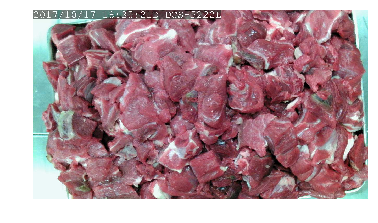

In [15]:
#随机查看图片
import cv2
import matplotlib.pyplot as plt
import random
import os
%matplotlib inline
dir_path ='./data/Fresh'
path = os.listdir(dir_path)
img_path=[]
for p in path:
    path_tmp = os.path.join(dir_path,p)
    img_path.append(path_tmp)
random.shuffle(img_path)
print(img_path[0])
img = cv2.imread(img_path[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off') # 不显示坐标轴
plt.show()   

# 三、模型介绍
本次使用paddlex完成分类任务  

## paddlex介绍
paddlex github地址：[https://github.com/PaddlePaddle/PaddleX](https://github.com/PaddlePaddle/PaddleX)

PaddleX -- 飞桨全流程开发工具，以低代码的形式支持开发者快速实现产业实际项目落地<br>
PaddleX 集成飞桨智能视觉领域图像分类、目标检测、语义分割、实例分割任务能力，将深度学习开发全流程从数据准备、模型训练与优化到多端部署端到端打通，并提供统一任务API接口及图形化开发界面Demo。开发者无需分别安装不同套件，以低代码的形式即可快速完成飞桨全流程开发。

🏭 PaddleX 经过质检、安防、巡检、遥感、零售、医疗等十多个行业实际应用场景验证，沉淀产业实际经验，并提供丰富的案例实践教程，全程助力开发者产业实践落地。
![](https://ai-studio-static-online.cdn.bcebos.com/220723d22e144fb9a1a5428186e3079196e5aafe35514d9f979b1f8b7d390742)


## 训练准备

In [ ]:
#安装paddlex
!pip install paddlex

In [ ]:
#导入包
import paddlex
import os

In [ ]:
#数据划分
!paddlex --split_dataset --format ImageNet --dataset_dir ./data --val_value 0.2 --test_value 0.1

In [7]:
#数据预处理，数据增强
from paddlex import transforms as T
train_transforms = T.Compose([
    T.MixupImage(mixup_epoch=-1),#进行muxup
    T.RandomDistort(),#随机像素内容变换
    T.RandomExpand(),#随机扩张图像
    T.RandomCrop(),#随机裁剪图片
    T.RandomHorizontalFlip(),#随机翻转图片
    T.Resize(target_size=256, interp='CUBIC'),
    # T.BatchRandomResize(
    #     target_sizes=[320, 352, 384, 416, 448, 480, 512, 544, 576, 608],
    #     interp='RANDOM'),#对batch进行批量裁剪
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])#归一化
]
)
eval_transforms = T.Compose([
    T.Resize(target_size=256, interp='CUBIC'),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])#归一化 
])

train_dataset=paddlex.datasets.ImageNet(
    data_dir='./data', 
    file_list='./data/train_list.txt', 
    label_list='./data/labels.txt', 
    transforms=train_transforms, 
    num_workers='auto', 
    shuffle=False)
eval_dataset=paddlex.datasets.ImageNet(
    data_dir='./data', 
    file_list='./data/val_list.txt', 
    label_list='./data/labels.txt', 
    transforms=eval_transforms, 
    num_workers='auto', 
    shuffle=False)

2022-02-23 10:37:24 [INFO]	Starting to read file list from dataset...
2022-02-23 10:37:24 [INFO]	1330 samples in file ./data/train_list.txt
2022-02-23 10:37:24 [INFO]	Starting to read file list from dataset...
2022-02-23 10:37:24 [INFO]	378 samples in file ./data/val_list.txt


# 四、模型训练


In [ ]:
#默认优化器：paddle.optimizer.lr.PiecewiseDecay衰减策略，paddle.optimizer.Momentum优化方法
#learning_rate=0.001
#epoch 100轮  提前结束
#batch_size 64

In [ ]:
#开启训练
model = paddlex.cls.ResNet50(num_classes=2)
model.train(
    num_epochs=50, #训练轮数
    train_dataset=train_dataset, #训练数据
    train_batch_size=64, #训练batch_size
    eval_dataset=eval_dataset, #验证数据
    optimizer=None, #优化器默认
    save_interval_epochs=10, #保存轮数
    log_interval_steps=10, #log输出steps数
    save_dir='output', #保存路径
    pretrain_weights='IMAGENET',#使用ImageNet图片数据上预训练的模型权重 
    learning_rate=0.001, #默认优化器的学习率
    warmup_steps=50, #认优化器进行warmup过程的步数
    warmup_start_lr=0.0, #认优化器进行warmup过程的步数
    lr_decay_epochs=(30, 40, 45), #认优化器进行warmup过程的步数
    use_vdl=True)#使用VisualDL进行可视化

W0222 11:32:11.889587   157 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0222 11:32:11.895375   157 device_context.cc:465] device: 0, cuDNN Version: 7.6.


2022-02-22 11:32:15 [INFO]	Downloading ResNet50_pretrained.pdparams from https://paddle-imagenet-models-name.bj.bcebos.com/dygraph/legendary_models/ResNet50_pretrained.pdparams


100%|██████████| 151051/151051 [00:06<00:00, 24705.88KB/s]


2022-02-22 11:32:21 [INFO]	Loading pretrained model from output/pretrain/ResNet50_pretrained.pdparams
2022-02-22 11:32:22 [WARNING]	[SKIP] Shape of pretrained params fc.weight doesn't match.(Pretrained: (2048, 1000), Actual: [2048, 2])
2022-02-22 11:32:22 [WARNING]	[SKIP] Shape of pretrained params fc.bias doesn't match.(Pretrained: (1000,), Actual: [2])
2022-02-22 11:32:22 [INFO]	There are 265/267 variables loaded into ResNet50.


# 五、模型评估

In [ ]:
#训练可视化
!visualdl --logdir='./output/vdl_log'

2022-02-23 10:40:03 [INFO]	Model[ResNet50] loaded.
./data/Fresh/test_20171017_150721D.jpg图片上的肉是 Spoiled


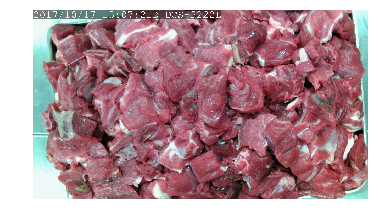

In [27]:
#结果预测
import cv2
import matplotlib.pyplot as plt
import random
%matplotlib inline

model=paddlex.load_model('./output/best_model')
with open('./data/test_list.txt') as f:
    img_path=f.readlines()
    random.shuffle(img_path)
    for path in img_path:
        path = './data/'+ path[:-3]
        # print(path)
        result = model.predict(path)
        print(f'{path}图片上的肉是',result[0]['category'])
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis('off') # 不显示坐标轴
        plt.show()    
        break

# 六、总结与升华
本次项目还是比较简单的，数据集类型比较少，只有红肉，之后可以多收集点别的类型的肉类数据进行训练。

# 七、个人总结
21年才开始接触深度学习，继续努力。<br>
个人主页:[https://aistudio.baidu.com/aistudio/personalcenter/thirdview/855343](https://aistudio.baidu.com/aistudio/personalcenter/thirdview/855343)